# Multitask Sequential

Train on multiple tasks one at a time. Follow order from clustering scores, namely start with task which had best clustering scores.

First some imports.

In [1]:
!nvidia-smi

Sat Jan 15 21:58:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   30C    P0    40W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

0

In [3]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
from datasets import load_metric
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, AutoModel
from datasets import Dataset, DatasetDict, ClassLabel, load_metric
from sklearn.model_selection import train_test_split


def quantize_feature(values, edges):
    labels = values.copy().astype(np.int)
    for i, _edge in enumerate(edges[:-1]):
        if i == 0:
            mask = values < edges[i+1]
        else:
            mask = np.logical_and(values >= edges[i], values < edges[i+1])
        labels[mask] = i
    return labels


def plot_confusion(predictions, true_vals, normalize=True):
    cf_matrix = confusion_matrix(true_vals, predictions, normalize="true" if normalize else None)
    fig, ax = plt.subplots(figsize=(8, 5)) 
    sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='.2g', vmin=0, vmax=1);
    ax.set_ylabel("GROUND TRUTH")
    ax.set_xlabel("PREDICTION");


def histedges_equalN(x, nbin, max_val=None):
    # https://stackoverflow.com/a/39419049
    npt = len(x)
    edges = np.interp(np.linspace(0, npt, nbin + 1), np.arange(npt), np.sort(x))
    if max_val:
        edges[-1] = max_val
    return edges


def create_datasets(tokenized_lyrics, feature, n=None, verbose=True, n_class=1, max_val=1):
    """
    n_class : if provided, quantize to this many classes with equal amount of per class
    n : to subset for testing purposes
    """
    lyrics_lab = tokenized_lyrics.copy()
    
    if feature == "genre":
        # already multiclass so different preparation
        labels_lst = sorted(list(set(df_clean["genre"])))
        labels = ClassLabel(names=labels_lst)
        lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", labels.str2int(train["genre"]))
        lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", labels.str2int(val["genre"]))
        lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", labels.str2int(test["genre"]))

        # cast to ClassLabel
        for _key in lyrics_lab.keys():
            new_features = lyrics_lab[_key].features.copy()
            new_features["labels"] = labels
            lyrics_lab[_key] = lyrics_lab[_key].cast(new_features)
            
    else:
    
        if n_class > 1:
            edges = histedges_equalN(train[feature].values, n_class, max_val=max_val)
            if verbose:
                print(edges)
            lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", quantize_feature(train[feature], edges))
            lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", quantize_feature(val[feature], edges))
            lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", quantize_feature(test[feature], edges))
        else:
            lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", train[feature])
            lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", val[feature])
            lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", test[feature])
            
    if verbose:
        print(lyrics_lab)
    
    if n is not None:
        lyrics_lab["train"] = lyrics_lab["train"].shuffle(seed=seed).select(range(n)) 
        lyrics_lab["validation"] = lyrics_lab["validation"].shuffle(seed=seed).select(range(n)) 
        lyrics_lab["test"] = lyrics_lab["test"].shuffle(seed=seed).select(range(n)) 
    
    if verbose:
        print(lyrics_lab["train"])
        print(lyrics_lab["validation"])
        print(lyrics_lab["test"])
            
    return lyrics_lab


def create_trainer(
    model_str,
    lyrics, 
    freeze_base_model, 
    feature, 
    batch_size, 
    n_epochs, 
    n_class=1,
    learning_rate=None, 
    n=None,
    verbose=True,
    max_val=1,
    output_dir=None,
    base_model_str=None
):
    """
    lyrics : DatasetDict object with "train", "validation", and "test" keys
    n_class : if provided, quantize to this many classes with equal amount of per class
    n : to subset for testing purposes
    """
    
    # tokenize lyrics
    tokenizer = AutoTokenizer.from_pretrained(model_str, use_fast=True)
    if model_str == "gpt2":
        tokenizer.pad_token = tokenizer.eos_token
    def preprocess_function(examples):
        return tokenizer(examples["text"], padding=True, truncation=True)
    tokenized_lyrics = lyrics.map(preprocess_function, batched=True)
    if verbose:
        print("tokenized lyrics", tokenized_lyrics)
    
    # label train, validation, test sets
    lyrics_lab = create_datasets(tokenized_lyrics, feature, n, verbose, n_class, max_val)
    if feature == "genre":
        # already multiclass so different preparation
        labels_lst = sorted(list(set(df_clean["genre"])))
        n_class = len(labels_lst)

    # create model
    print("LOADING MODEL")
    model = AutoModelForSequenceClassification.from_pretrained(model_str, num_labels=n_class)
    if base_model_str:
        # copy base model from provided model
        other_model = AutoModelForSequenceClassification.from_pretrained(base_model_str)
        # https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/4
#         model.base_model = copy.deepcopy(other_model.base_model)
        # https://discuss.pytorch.org/t/does-deepcopying-optimizer-of-one-model-works-across-the-model-or-should-i-create-new-optimizer-every-time/14359/2
        model.base_model.load_state_dict(other_model.base_model.state_dict())
        
    if freeze_base_model:
        for name, param in model.named_parameters():
            if 'classifier' not in name: # classifier layer
                param.requires_grad = False
        if learning_rate is None:
            learning_rate = 2e-3
    else:
        if learning_rate is None:
            learning_rate = 2e-5
        for name, param in model.named_parameters():
            param.requires_grad = True
            
    # set up training
    if output_dir is None:
        
        if os.path.isdir(model_str):
            output_dir = model_str.replace("/", "-")
            if not freeze_base_model:
                output_dir = output_dir.replace("_frozen", "_unfrozen")
        else:
            output_dir = f"{os.path.basename(model_str)}-finetuned-{feature}"
            if n_class > 1 and feature != "genre":
                output_dir += f"_quant{n_class}"
            if freeze_base_model:
                output_dir += "_frozen_base"
            if n:
                output_dir += f"_TEST{n}"
    if verbose:
        print(learning_rate)
        print(output_dir)
    training_args = TrainingArguments(
        output_dir, 
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=n_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy" if n_class > 1 else None,
    )
    
    if n_class > 1:
        metric = load_metric("accuracy")
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            return metric.compute(predictions=predictions, references=labels)
    else:
        compute_metrics = None

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lyrics_lab["train"],
        eval_dataset=lyrics_lab["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    return trainer, lyrics_lab["train"], lyrics_lab["validation"], lyrics_lab["test"]



df_clean = pd.read_pickle('df_clean_v4_14122021_py35.pkl')
print(df_clean.shape)
df_clean.head()

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


(15863, 17)


,lyrics,explicit,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year,artist,genre
song_id,,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019,Ariana Grande,dance pop
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018,Halsey,dance pop
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018,Travis Scott,hip-hop/rap
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018,Panic! At The Disco,rock
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994,Mariah Carey,dance pop


In [4]:
df_clean["genre"].value_counts()

rock             3476
pop              2774
country          2412
soul/disco       2339
dance pop        2082
hip-hop/rap      1472
r&b               972
acoustic/folk     336
Name: genre, dtype: int64

# 1) split dataset

In [5]:
seed = 11
val_size = 0.15
test_size = 0.15
train, _eval = train_test_split(
    df_clean, test_size=val_size + test_size, random_state=seed, stratify=df_clean['genre']
)
val, test = train_test_split(
    _eval, test_size=test_size / (val_size + test_size), random_state=seed, stratify=_eval['genre']
)

print(train.shape)
print(val.shape)
print(test.shape)

(11104, 17)
(2379, 17)
(2380, 17)


In [6]:
lyrics = DatasetDict()

# arguments expected by forward: https://github.com/huggingface/transformers/blob/9aeacb58bab321bc21c24bbdf7a24efdccb1d426/src/transformers/modeling_bert.py#L1313
lyrics["train"] = Dataset.from_dict({"text": list(train["lyrics"])})
lyrics["validation"] = Dataset.from_dict({"text": list(val["lyrics"])})
lyrics["test"] = Dataset.from_dict({"text": list(test["lyrics"])})

print(lyrics)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2380
    })
})


# 2) Fine-tune genre model on valence

first we freeze base layers to train classifier with larger learning rate

In [7]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="sentence-transformers/all-mpnet-base-v2",
    lyrics=lyrics, 
    feature="valence", 
    batch_size=32, 
    n_epochs=5,
    freeze_base_model=True,
    n_class=2,
    output_dir="mpnet-genre-finetuned-frozen-valence",
    base_model_str="all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735"
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0349 0.625  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a

0.002
mpnet-genre-finetuned-frozen-valence


In [8]:
trainer.train()
# trainer.train(resume_from_checkpoint=True)

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.661667,0.630937
2,0.648300,0.651217,0.623792
3,0.636300,0.638338,0.633880
4,0.636300,0.635799,0.634720
5,0.630000,0.636737,0.635561


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-finetuned-frozen-valence/checkpoint-347
Configuration saved in mpnet-genre-finetuned-frozen-valence/checkpoint-347/config.json
Model weights saved in mpnet-genre-finetuned-frozen-valence/checkpoint-347/pytorch_model.bin
tokenizer config file saved in mpnet-genre-finetuned-frozen-valence/checkpoint-347/tokenizer_config.json
Special tokens file saved in mpnet-genre-finetuned-frozen-valence/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-finetuned-frozen-valence/checkpoint-694
Co

TrainOutput(global_step=1735, training_loss=0.636303798884411, metrics={'train_runtime': 911.5665, 'train_samples_per_second': 60.906, 'train_steps_per_second': 1.903, 'total_flos': 1.46079257935872e+16, 'train_loss': 0.636303798884411, 'epoch': 5.0})

In [9]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


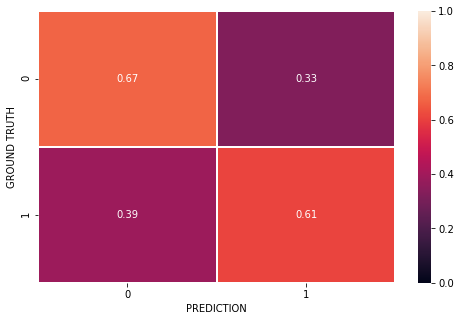

In [10]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

### now unfreeze base layers and train with small learning rate

regarding warning of layers not being used: https://discuss.huggingface.co/t/message-some-layers-from-the-model-were-not-used/1972/4

In [7]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="mpnet-genre-finetuned-frozen-valence/checkpoint-1735",
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="valence", 
    batch_size=32, 
    n_epochs=3,
    n_class=2,
    learning_rate=2e-6,
    output_dir="mpnet-genre-valence-finetuned",
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0349 0.625  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

In [8]:
trainer.train()
# trainer.train(resume_from_checkpoint=True)

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.631546,0.645649
2,0.603700,0.631247,0.644388
3,0.589800,0.632524,0.647331


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-finetuned/checkpoint-347
Configuration saved in mpnet-genre-valence-finetuned/checkpoint-347/config.json
Model weights saved in mpnet-genre-valence-finetuned/checkpoint-347/pytorch_model.bin
tokenizer config file saved in mpnet-genre-valence-finetuned/checkpoint-347/tokenizer_config.json
Special tokens file saved in mpnet-genre-valence-finetuned/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-finetuned/checkpoint-694
Configuration saved in mpnet-genre-valence-f

TrainOutput(global_step=1041, training_loss=0.5966088517598529, metrics={'train_runtime': 1272.3101, 'train_samples_per_second': 26.182, 'train_steps_per_second': 0.818, 'total_flos': 8764755476152320.0, 'train_loss': 0.5966088517598529, 'epoch': 3.0})

In [9]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


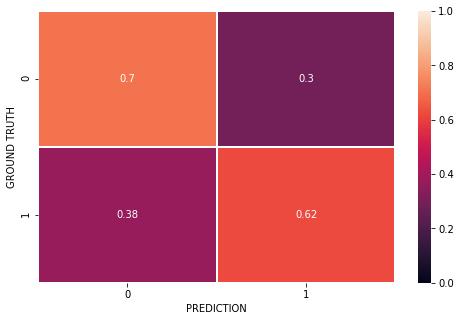

In [10]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 3) Fine-tune on energy

In [7]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="mpnet-genre-valence-finetuned/checkpoint-1041",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature="energy", 
    batch_size=32, 
    n_epochs=5,
    n_class=2,
    output_dir="mpnet-genre-valence-finetuned-frozen-energy"
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0223 0.656  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

In [8]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.643839,0.649012
2,0.636700,0.631518,0.642287
3,0.618300,0.629670,0.641446
4,0.618300,0.639837,0.643968
5,0.608800,0.627962,0.644809


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-finetuned-frozen-energy/checkpoint-347
Configuration saved in mpnet-genre-valence-finetuned-frozen-energy/checkpoint-347/config.json
Model weights saved in mpnet-genre-valence-finetuned-frozen-energy/checkpoint-347/pytorch_model.bin
tokenizer config file saved in mpnet-genre-valence-finetuned-frozen-energy/checkpoint-347/tokenizer_config.json
Special tokens file saved in mpnet-genre-valence-finetuned-frozen-energy/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence

TrainOutput(global_step=1735, training_loss=0.6192437251637923, metrics={'train_runtime': 933.474, 'train_samples_per_second': 59.477, 'train_steps_per_second': 1.859, 'total_flos': 1.46079257935872e+16, 'train_loss': 0.6192437251637923, 'epoch': 5.0})

In [9]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


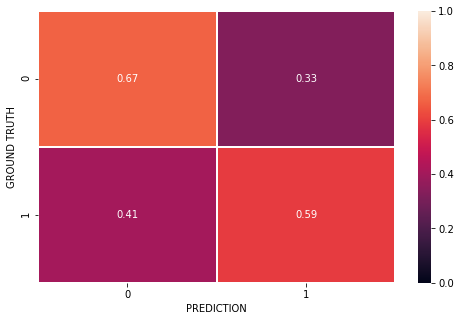

In [10]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

### now unfreeze base layers and train with small learning rate

In [7]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="mpnet-genre-valence-finetuned-frozen-energy/checkpoint-1735",   # smaller train and val loss
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="energy", 
    batch_size=32, 
    n_epochs=3,
    n_class=2,
    learning_rate=2e-6,
    output_dir="mpnet-genre-valence-energy-finetuned",
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0223 0.656  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

In [8]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.622570,0.656578
2,0.583500,0.624678,0.659521
3,0.566200,0.624571,0.653636


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-energy-finetuned/checkpoint-347
Configuration saved in mpnet-genre-valence-energy-finetuned/checkpoint-347/config.json
Model weights saved in mpnet-genre-valence-energy-finetuned/checkpoint-347/pytorch_model.bin
tokenizer config file saved in mpnet-genre-valence-energy-finetuned/checkpoint-347/tokenizer_config.json
Special tokens file saved in mpnet-genre-valence-energy-finetuned/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-energy-finetuned/checkpoint-694
Co

TrainOutput(global_step=1041, training_loss=0.5747574926224268, metrics={'train_runtime': 1271.494, 'train_samples_per_second': 26.199, 'train_steps_per_second': 0.819, 'total_flos': 8764755476152320.0, 'train_loss': 0.5747574926224268, 'epoch': 3.0})

In [9]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


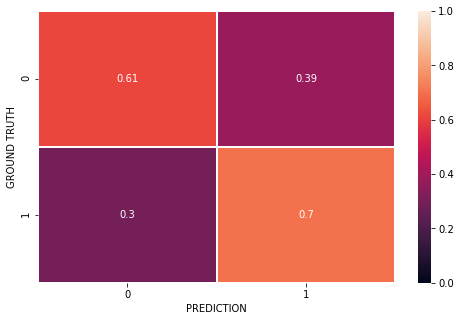

In [10]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 4) Fine-tune on danceability

In [8]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="mpnet-genre-valence-energy-finetuned/checkpoint-694",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature="danceability", 
    batch_size=32, 
    n_epochs=5,
    n_class=2,
    output_dir="mpnet-genre-valence-energy-finetuned-frozen-danceability"
)

Didn't find file mpnet-genre-valence-energy-finetuned/checkpoint-694/added_tokens.json. We won't load it.
loading file mpnet-genre-valence-energy-finetuned/checkpoint-694/vocab.txt
loading file mpnet-genre-valence-energy-finetuned/checkpoint-694/tokenizer.json
loading file None
loading file mpnet-genre-valence-energy-finetuned/checkpoint-694/special_tokens_map.json
loading file mpnet-genre-valence-energy-finetuned/checkpoint-694/tokenizer_config.json


  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

loading configuration file mpnet-genre-valence-energy-finetuned/checkpoint-694/config.json
Model config MPNetConfig {
  "_name_or_path": "mpnet-genre-valence-finetuned-frozen-energy/checkpoint-1735",
  "architectures": [
    "MPNetForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "vocab_size": 30527
}

loading weights file mpnet-genre-valence-energy-finetuned/checkpoint-694/pytorch_model.bin


tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.103 0.603 1.   ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 

All model checkpoint weights were used when initializing MPNetForSequenceClassification.

All the weights of MPNetForSequenceClassification were initialized from the model checkpoint at mpnet-genre-valence-energy-finetuned/checkpoint-694.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MPNetForSequenceClassification for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


0.002
mpnet-genre-valence-energy-finetuned-frozen-danceability


In [9]:
trainer.train()
# trainer.train(resume_from_checkpoint=True)

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.632715,0.643968
2,0.617000,0.627307,0.646910
3,0.602100,0.609413,0.659941
4,0.602100,0.608051,0.654477
5,0.591000,0.602312,0.662463


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-energy-finetuned-frozen-danceability/checkpoint-347
Configuration saved in mpnet-genre-valence-energy-finetuned-frozen-danceability/checkpoint-347/config.json
Model weights saved in mpnet-genre-valence-energy-finetuned-frozen-danceability/checkpoint-347/pytorch_model.bin
tokenizer config file saved in mpnet-genre-valence-energy-finetuned-frozen-danceability/checkpoint-347/tokenizer_config.json
Special tokens file saved in mpnet-genre-valence-energy-finetuned-frozen-danceability/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379

TrainOutput(global_step=1735, training_loss=0.6012583092241535, metrics={'train_runtime': 986.1005, 'train_samples_per_second': 56.303, 'train_steps_per_second': 1.759, 'total_flos': 1.46079257935872e+16, 'train_loss': 0.6012583092241535, 'epoch': 5.0})

In [10]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


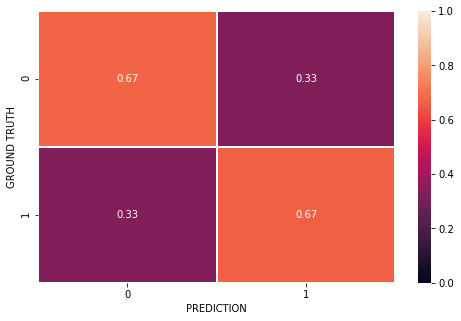

In [11]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

### now unfreeze base layers and train with small learning rate

In [8]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="mpnet-genre-valence-energy-finetuned-frozen-danceability/checkpoint-1735",
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="danceability", 
    batch_size=32, 
    n_epochs=3,
    n_class=2,
    learning_rate=2e-6,
    output_dir="mpnet-genre-valence-energy-danceability-finetuned",
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.103 0.603 1.   ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 

In [10]:
# trainer.train()
trainer.train(resume_from_checkpoint="mpnet-genre-valence-energy-danceability-finetuned/checkpoint-694")

Loading model from mpnet-genre-valence-energy-danceability-finetuned/checkpoint-694).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 694
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy
3,0.560800,0.603077,0.666246


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041
Configuration saved in mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041/config.json
Model weights saved in mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041/pytorch_model.bin
tokenizer config file saved in mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041/tokenizer_config.json
Special tokens file saved in mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041 (score: 0.6662463219840269).


TrainOutput(global_step=1041, training_loss=0.18682862427461389, metrics={'train_runtime': 444.1242, 'train_samples_per_second': 75.006, 'train_steps_per_second': 2.344, 'total_flos': 9640389068390400.0, 'train_loss': 0.18682862427461389, 'epoch': 3.0})

In [11]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


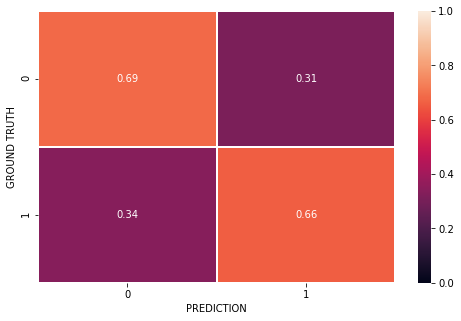

In [12]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 5) Fine-tune again on genre

to not get stuck on two classes / clusters

In [7]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
#     model_str="sentence-transformers/all-mpnet-base-v2",
    model_str="all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735",
    lyrics=lyrics, 
    feature="genre", 
    batch_size=32, 
    n_epochs=5,
    freeze_base_model=True,
    output_dir="mpnet-genre-valence-energy-danceability-finetuned-frozen-genre",
    base_model_str="mpnet-genre-valence-energy-danceability-finetuned/checkpoint-1041"
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})


Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})
LOADING MODEL
0.002
mpnet-genre-valence-energy-danceability-finetuned-frozen-genre


In [8]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.975945,0.456915
2,0.651100,2.061285,0.454813
3,0.594600,2.116096,0.454813
4,0.594600,2.055464,0.460698
5,0.595000,2.018153,0.461538


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-energy-danceability-finetuned-frozen-genre/checkpoint-347
Configuration saved in mpnet-genre-valence-energy-danceability-finetuned-frozen-genre/checkpoint-347/config.json
Model weights saved in mpnet-genre-valence-energy-danceability-finetuned-frozen-genre/checkpoint-347/pytorch_model.bin
tokenizer config file saved in mpnet-genre-valence-energy-danceability-finetuned-frozen-genre/checkpoint-347/tokenizer_config.json
Special tokens file saved in mpnet-genre-valence-energy-danceability-finetuned-frozen-genre/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluati

TrainOutput(global_step=1735, training_loss=0.6241518487847848, metrics={'train_runtime': 934.2346, 'train_samples_per_second': 59.428, 'train_steps_per_second': 1.857, 'total_flos': 1.460871274561536e+16, 'train_loss': 0.6241518487847848, 'epoch': 5.0})

In [9]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


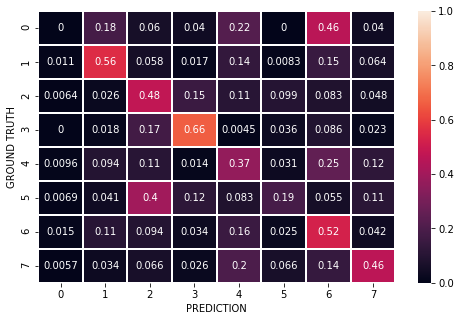

In [10]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

### now unfreeze base layers and train with small learning rate

In [7]:
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="mpnet-genre-valence-energy-danceability-finetuned-frozen-genre/checkpoint-1735",
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="genre", 
    batch_size=32, 
    n_epochs=3,
    learning_rate=2e-6,
    output_dir="mpnet-genre-valence-energy-danceability-genre-finetuned",
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})


Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})
LOADING MODEL
2e-06
mpnet-genre-valence-energy-danceability-genre-finetuned


In [8]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.046608,0.452291
2,0.421000,2.073892,0.454393
3,0.370300,2.057786,0.456915


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-347
Configuration saved in mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-347/config.json
Model weights saved in mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-347/pytorch_model.bin
tokenizer config file saved in mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-347/tokenizer_config.json
Special tokens file saved in mpnet-genre-valence-energy-danceability-genre-finetuned/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Ba

TrainOutput(global_step=1041, training_loss=0.39435597455467203, metrics={'train_runtime': 1271.8128, 'train_samples_per_second': 26.193, 'train_steps_per_second': 0.819, 'total_flos': 8765227647369216.0, 'train_loss': 0.39435597455467203, 'epoch': 3.0})

In [9]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


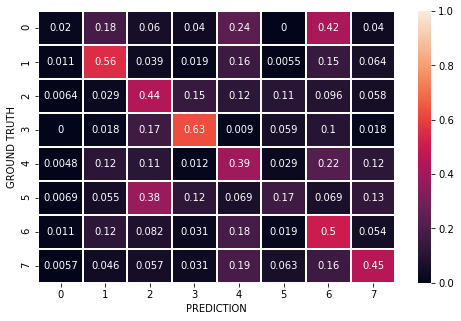

In [10]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)